# Monte Carlo

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [ ]:
import sys
import gym
import numpy as np
from collections import defaultdict

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Use the code cell below to create an instance of the [Blackjack environment](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py).

In [ ]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [ ]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.

(The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times. The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment.)

In [ ]:
for episod in range(3):
    state = env.reset()

    while True:
        print(state)

        # random action
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        print(state, action, reward)

        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(20, 10, False)
(27, 10, False) 1 -1.0
End game! Reward:  -1.0
You lost :(

(11, 3, False)
(11, 3, False) 0 -1.0
End game! Reward:  -1.0
You lost :(

(19, 9, False)
(21, 9, False) 1 0.0
(21, 9, False)
(26, 9, False) 1 -1.0
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction
In this section, you will write your own implementation of MC prediction (for estimating the action-value function).

We will begin by investigating a policy where the player *almost* always sticks if the sum of her cards exceeds 18. In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability. The function `generate_episode_from_limit_stochastic` samples an episode using this policy.

The function accepts as **input**:

* `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:

* `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to  (𝑆0,𝐴0,𝑅1,…,𝑆𝑇−1,𝐴𝑇−1,𝑅𝑇) , where  𝑇  is the final time step. In particular, `episode[i]` returns  (𝑆𝑖,𝐴𝑖,𝑅𝑖+1) , and episode[i][0], episode[i][1], and episode[i][2] return  𝑆𝑖 ,  𝐴𝑖 , and  𝑅𝑖+1 , respectively.

In [ ]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()

    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append([state, action, reward])
        state = next_state

        if done:
            break

    return episode

Execute the code cell below to play Blackjack with the policy.

In [ ]:
for _ in range(3):
    print(generate_episode_from_limit_stochastic(env))

[[(8, 1, False), 1, 0.0], [(14, 1, False), 1, -1.0]]
[[(11, 10, False), 1, 0.0], [(21, 10, False), 1, -1.0]]
[[(17, 10, False), 1, -1.0]]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print(f'\rEpisode {i_episode}/{num_episodes}.', end='')
            sys.stdout.flush()

        # generate an episode - obtain the states, actions, and rewards
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)

        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards) + 1)])

        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:] * discounts[:-(1 + i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]

    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 5000, generate_episode_from_limit_stochastic)

Episode 5000/5000.

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def generate_episode_from_Q(env, Q, epsilon, num_of_actions):
    """Generates an episode from following the epsilon-greedy policy"""
 
    episode = []
    state = env.reset()

    while True:
        if state in Q:
            action = np.random.choice(np.arange(num_of_actions), p=get_probs(Q[state], epsilon, num_of_actions))
        else:
            action = env.action_space.sample()

        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state

        if done:
            break

    return episode


def get_probs(Q_state, epsilon, num_of_actions):
    """Obtains the action probabilities corresponding to epsilon-greedy policy"""

    policy_s = np.ones(num_of_actions) * epsilon / num_of_actions
    best_action = np.argmax(Q_state)
    policy_s[best_action] = 1 - epsilon + (epsilon / num_of_actions)
    
    return policy_s


def update_Q(env, episode, Q, alpha, gamma):
    """Updates the action-value function estimate using the most recent episode"""

    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma ** i for i in range(len(rewards) + 1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha * (sum(rewards[i:] * discounts[:-(1 + i)]) - old_Q)

    return Q

In [ ]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    num_of_actions = env.action_space.n

    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(num_of_actions))
    epsilon = eps_start

    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print(f'\rEpisode {i_episode}/{num_episodes}.', end='')
            sys.stdout.flush()

        # set the value of epsilon
        epsilon = max(epsilon * eps_decay, eps_min)

        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, num_of_actions)

        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((key, np.argmax(val)) for key, val in Q.items())

    return policy, Q

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

In [ ]:
for i, (state, action) in enumerate(policy.items()):
    if i == 10:
        break

    print(state, action)

(14, 6, False) 0
(7, 10, False) 1
(18, 10, True) 1
(20, 10, False) 0
(17, 5, False) 0
(17, 1, False) 1
(16, 10, False) 1
(19, 10, False) 0
(20, 5, False) 0
(13, 10, False) 1


In [ ]:
len(policy)

280

In [ ]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

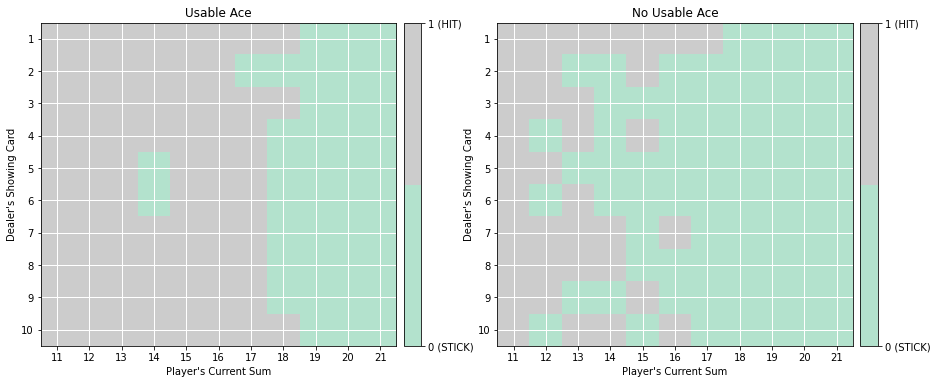

In [ ]:
# plot the policy
plot_policy(policy)

Compare your final estimate to the optimal policy - how close are you able to get? If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of  𝜖 , change the value of  𝛼 , and/or run the algorithm for more episodes to attain better results.

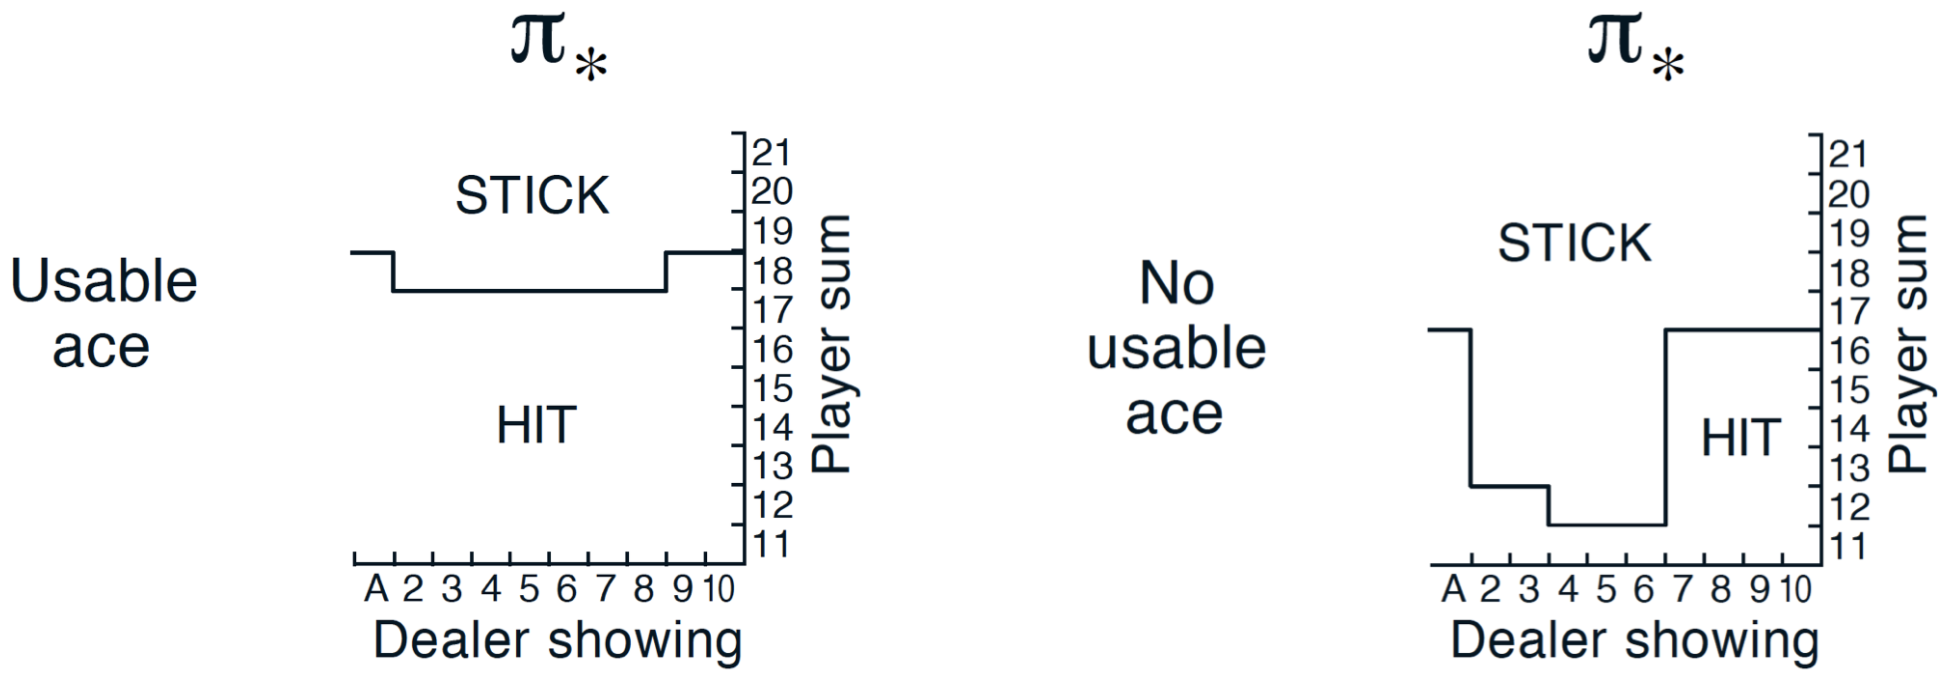